In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# import gsw
from matplotlib.ticker import MaxNLocator
import itertools

import cartopy as cart
import cartopy.crs as ccrs  
import cmocean.cm as cmo
import seaborn as sns
from glob import glob
import cartopy.feature as cfeature
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import analysis_functions as funk
from cartopy import geodesic
import shapely
import cartopy

In [2]:
initial_depth = -5000  # int(sys.argv[1])  # 5 # 60 # 5179
lon_sample = 6.287  # 6.25
lat_sample = -32.171  # -32.171
origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-20 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4484
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

depth_bins = np.linspace(-5500, 0, 56)  # creates a 100m bins

simulations = [100, 1000, 10000, 23000]
sim_names = [100, 1000, 10000, 23000]

In [3]:
surface_events = {}

for k, ft in enumerate(tqdm(simulations)):
    # print('Computing fragmentation timescale: ', ft)
    local_path = f'/storage/shared/oceanparcels/output_data/data_Claudio/hc13_3/hc13_{ft}.zarr'
    sim = xr.open_zarr(local_path)

    # loading fields as np arrays to do some nasty indexing
    radiuses = sim['radius'].values
    depths = sim['z'].values
    latitudes = sim['lat'].values
    longitudes = sim['lon'].values
    frag_events = sim['frag_events'].values
    d_2_shore = sim['distance'].values

    df_sim = {}  # dictiorany to store data per sim. Could be a pandas DF

    # Detecting the index and the particles that reach the surface
    k1, k2 = np.where(depths < 30)
    idx_particles, idx_k2 = np.unique(k1, return_index=True)
    surface_time = k2[idx_k2]
    
    m1, m2 = np.where(radiuses > 1e-4)
    _, idx_m2 = np.unique(m1, return_index=True)
    time_fragmetation = m2[idx_m2]

    df_sim['particle_index'] = idx_particles
    df_sim['surface_time'] = surface_time  # Days. equivalent to index in simus
    df_sim['radius'] = radiuses[idx_particles, surface_time]
    df_sim['depths'] = depths[idx_particles, surface_time]
    df_sim['frag_events'] = frag_events[idx_particles, surface_time]
    df_sim['frag_time'] = time_fragmetation
    df_sim['d2shore'] = d_2_shore[idx_particles, surface_time]

    latz = latitudes[idx_particles, surface_time]
    lonz = longitudes[idx_particles, surface_time]
    xy_pos = (lonz, latz)

    df_sim['displacement'] = funk.haversine(origin, xy_pos)
    df_sim['lat'] = latz
    df_sim['lon'] = lonz

    surface_events[sim_names[k]] = df_sim  # Storing the dictionaris in another dict


  0%|          | 0/4 [00:00<?, ?it/s]

/nethome/6525954/.conda/envs/abyssal-nps/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 25%|██▌       | 1/4 [00:11<00:35, 11.99s/it]/nethome/6525954/.conda/envs/abyssal-nps/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
 50%|█████     | 2/4 [00:14<00:12,  6.13s/it]/nethome/6525954/.conda/envs/abyssal-nps/lib/python3.8/site-packages/xarray/coding/times.py:250: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
100%|██████████| 4/4 [00:17<00:00,  4.47s/it]


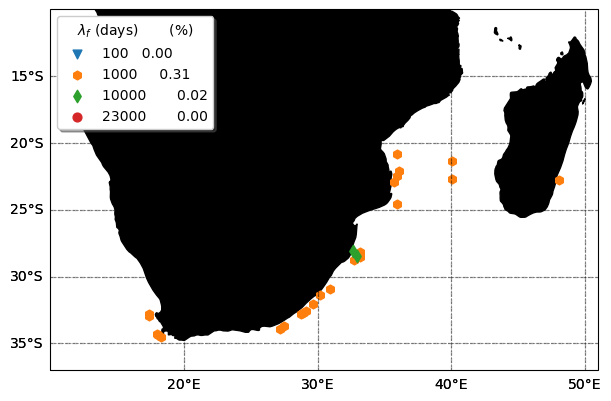

In [4]:
marker = itertools.cycle(('v', 'h', 'd', 'o', 'X', 'P', '^', 's'))

fig,ax = plt.subplots(figsize=(6,6),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_extent([10, 51,-37, -10], crs=ccrs.PlateCarree())

# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1, color='black')
# ax.add_feature(cfeature.COASTLINE)


shoreparticles = {}
fill_characters = [0, 2, 4,4,4,4,4,6]


for j, ft in enumerate(simulations):
    shore_particles = np.where(surface_events[ft]['d2shore'] < 10)
    correction = np.where(surface_events[ft]['lon'][shore_particles] > 10)
    shore_particles = shore_particles[0][correction]
    proportion = len(shore_particles) / 2**13 * 100
    shoreparticles[ft] = len(shore_particles)

    
    ax.scatter(surface_events[ft]['lon'][shore_particles],
           surface_events[ft]['lat'][shore_particles], s=40, transform=ccrs.PlateCarree(), 
           label=f"{ft} {' '*fill_characters[j]}  {proportion:.2f}", marker=next(marker))
    

handles, labels = ax.get_legend_handles_labels()


ax.legend(shadow=True, title='$\lambda_f$ (days)       (%)', loc='upper left')


In [21]:
for j, ft in enumerate(simulations):
    median = np.median(surface_events[ft]['surface_time'])
    minimum = np.min(surface_events[ft]['surface_time'])
    
    print(f"FT: {ft}. Median: {median} days, Minimum: {minimum} days")

FT: 100. Median: 310.0 days, Minimum: 19 days
FT: 1000. Median: 2152.0 days, Minimum: 38 days
FT: 10000. Median: 3324.0 days, Minimum: 219 days
FT: 23000. Median: 3071.0 days, Minimum: 691 days


In [24]:
2152/365

5.895890410958904

In [9]:
Stats_surface = {}

for j, ft in enumerate(simulations[::-1]):
    number_surface = len(surface_events[ft]['particle_index'])/2**13*100
    fraction_shore = shoreparticles[ft]#/2**13*100
    
    Stats_surface[ft] = [number_surface, fraction_shore]
    # print(ft, ' '*fill_characters[j], number_surface, ' '*fill_characters[j], fraction_shore)

In [10]:
pd.DataFrame(Stats_surface, index=['Number of particles at surface (%)', 'Number of particles at shore (%)']).T

,Number of particles at surface (%),Number of particles at shore (%)
23000,0.769043,0.0
10000,4.394531,2.0
1000,86.315918,25.0
100,100.000000,0.0


In [20]:
310/365*12

10.191780821917808

In [17]:
2152/365

5.895890410958904

In [15]:
2/(8192)*100

0.0244140625

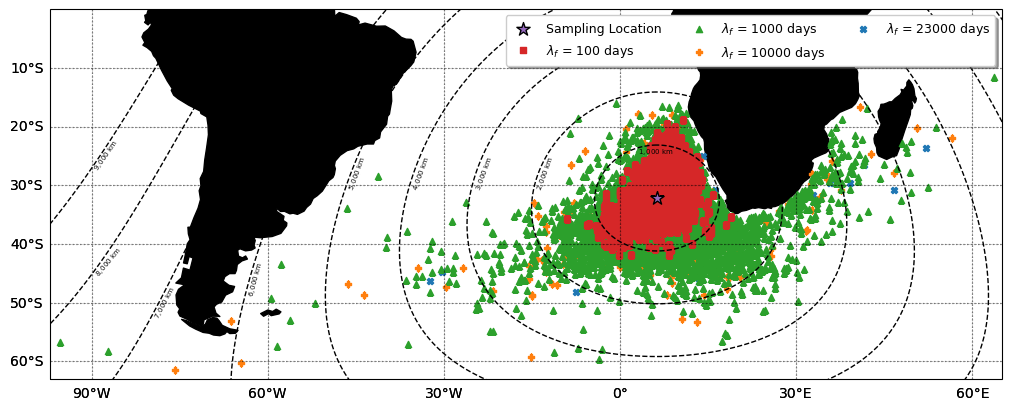

In [8]:
fig,ax = plt.subplots(figsize=(10,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1, color='black')
# ax.add_feature(cfeature.COASTLINE)

for j, ft in enumerate(simulations[::-1]):
    ax.scatter(surface_events[ft]['lon'], surface_events[ft]['lat'],
               zorder=2, s=20,
               label=f"$\lambda_f$ = {ft} days", marker=next(marker))

ax.scatter(origin[0], origin[1], zorder=5,
           label='Sampling Location', marker='*', s=100, edgecolors='black')

for r in range(1, 10):
    circle_points = geodesic.Geodesic().circle(lon=origin[0], lat=origin[1],
                                               radius=r*1e6,
                                               n_samples=360,
                                               endpoint=False)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none',
                      edgecolor='black', linewidth=1., zorder=3, ls='--',
                      label=f'{r} km')
    
handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]

ax.legend(handles, labels, ncols=3, fontsize=9, shadow=True)

ax.text(3,-24.5, r"$1,000$ km", fontsize=5)
ax.text(-14.5,-30.5, r"$2,000$ km", fontsize=5, rotation=70)
ax.text(-25.0,-30.5, r"$3,000$ km", fontsize=5, rotation=70)
ax.text(-35.6,-30.5, r"$4,000$ km", fontsize=5, rotation=70)
ax.text(-46.6,-30.5, r"$5,000$ km", fontsize=5, rotation=70)
ax.text(-63.7,-48.5, r"$6,000$ km", fontsize=5, rotation=75)
ax.text(-79.7,-52.5, r"$7,000$ km", fontsize=5, rotation=62)
ax.text(-89.7,-45.3, r"$8,000$ km", fontsize=5, rotation=50)
ax.text(-90.,-27.3, r"$9,000$ km", fontsize=5, rotation=55)
ax.set_extent([-97, 65, -63, 0], crs=ccrs.PlateCarree())

In [73]:
frag_into_NPs = np.load('../data/frag_into_NPs.npy', allow_pickle=True)[()]

Text(0.001, 0, 'B')

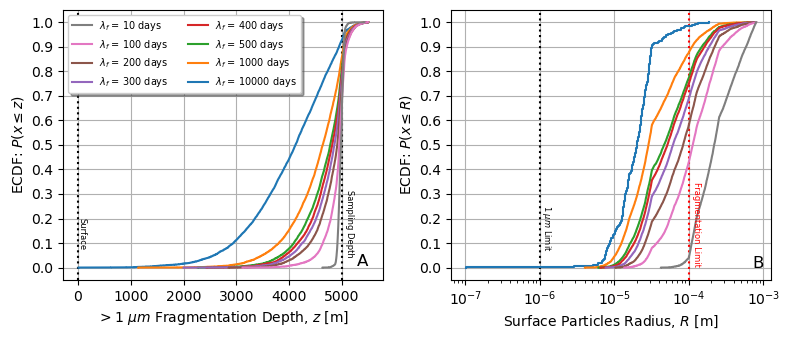

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), tight_layout=True)

ax[0].axvline(-initial_depth, ls=':', color='k')
ax[0].text(-initial_depth + 50, 0.05, r'Sampling Depth', fontsize=6, color='k', rotation=-90)
ax[0].axvline(0, ls=':', color='k')
ax[0].text(0, 0.08, r'Surface', fontsize=6, color='k', rotation=-90)

ax[1].axvline(1e-6, ls=':', color='black')
ax[1].axvline(1e-4, ls=':', label=r"Fragmentation limit", color='red')
ax[1].text(1e-6, 0.08, r"1 $\mu m$ Limit", fontsize=6, color='k', rotation=-90)
ax[1].text(1.1e-4, 0.01, r"Fragmentation Limit", fontsize=6, color='r', rotation=-90)

for j, ft in enumerate(simulations[::-1]):

    x, y = funk.ecdf(abs(frag_into_NPs[ft]['depths']), normalized=True,
                     invert=False)
    ax[0].plot(x, y, drawstyle='steps-post', label=f'$\lambda_f$ = {ft} days')
    
    x, y = funk.ecdf(frag_into_NPs[ft]['particle_index'], normalized=True,
                     invert=False)
    
    x, y = funk.ecdf(surface_events[ft]['radius'], normalized=True)
    ax[1].plot(x, y, drawstyle='steps-post')


handles, labels = ax[0].get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]

ax[0].legend(handles, labels, fontsize=7, shadow=True, ncol=2,
         loc='best')

ax[0].set_xlabel('$>1\ \mu m$ Fragmentation Depth, $z$ [m]')
ax[0].set_ylabel(r'ECDF: $P(x \leq z)$')

ax[1].semilogx()
ax[1].set_xlabel('Surface Particles Radius, $R$ [m]')
ax[1].set_ylabel(r'ECDF: $P(x \leq R)$')

gridy = np.linspace(0, 1, 11)
gridx = [500, 1000] + [i for i in range(2000, 10000, 2000)]

ax[0].set_yticks(gridy)
ax[1].set_yticks(gridy)

ax[0].grid()
ax[1].grid()

ax[0].text(5500, 0.005, r'A', fontsize=12,
               ha='right')
ax[1].text(1e-3, 0, r'B', fontsize=12,
               ha='right')